## Signed Cumulative Distribution Transform Nearest Subspace (SCDT-NS) Classifier

This tutorial will demonstrate how to use the SCDT-NS classifier from the *PyTransKit* package to classify 1D signals.

## Class:: SCDT_NS
**Functions**:

1. Constructor function:
        scdt_ns_obj = SCDT_NS(num_classes, rm_edge)
        
        Inputs:
        ----------------
        num_classes : integer value
            totale number of classes in the dataset.
        rm_edge : [optional] boolean 
            IF TRUE the first and last points of CDTs will be removed.
            
        Outputs:
        ----------------
        scdt_ns_obj : class object
            Instance of the class SCDT_NS.
            
2. Fit function:
        scdt_ns_obj.fit(Xtrain, Ytrain, Ttrain)
        
        Inputs:
        ----------------
        Xtrain : array-like, shape (n_samples, n_columns)
            1D data for training.
        Ytrain : ndarray of shape (n_samples,)
            Labels of the training samples.
        Ttrain : [optional] array-like, shape (n_samples, n_columns)
            domain for corresponding training signals.
  
3. Predict function:
        preds = scdt_ns_obj.predict(Xtest, Ttest, use_gpu)
        
        Inputs:
        ----------------
        Xtest : array-like, shape (n_samples, n_columns)
            1D data for testing.
        Ttest : [optional] array-like, shape (n_samples, n_columns)
            domain for corresponding test signals.
        use_gpu: [optional] boolean flag; IF TRUE, use gpu for calculations
            default = False.
            
        Outputs:
        ----------------
        preds : 1d array, shape (n_samples,)
           Predicted labels for test samples.
    

## Example
The following example will demonstrate how to:
* create and initialize an instance of the class SCDT_NS
* train the model using 1D signals
* apply the model to predict calss labels of the test 1D samples
In this example we have used a synthetic dataset (1D). The dataset contains three classes.<br>
Class 0: 4-th degree polynomial applied to a Gabor wave<br>
Class 1: 4-th degree polynomial applied to a sawtooth wave<br>
Class 2: 4-th degree polynomial applied to a square wave

### Import python libraries

In [1]:
import numpy as np
from numpy import interp
import math
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy import signal

import sys
sys.path.append('../')
from pytranskit.classification.utils import *

### Import SCDT-NS class from PyTransKit package

In [2]:
from pytranskit.classification.scdt_ns import SCDT_NS

### Define a three template signals: Gabor wave, sawtooth wave, square wave

In [3]:
def signal_gabor(t):
    w = 30
    s1 = np.real(math.pi**-0.25 * np.exp(2*math.pi*1j*w*(t-0.5)) * np.exp(-200*((t-0.5)**2)))
    return s1

def signal_sawtooth(t):
    s2 = signal.sawtooth(2 * np.pi * 15 * (t-0.5))* np.exp(-250*((t-0.5)**2))
    return s2

def signal_square(t):
    s3 = signal.square(2 * np.pi * 15 * (t-0.5))*np.exp(-250*((t-0.5)**2))
    return s3

### Generate template signals for three classes

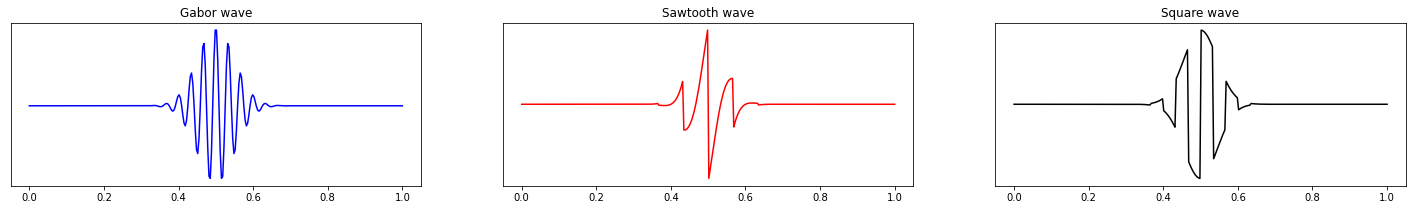

In [4]:
N = 300  # number of discrete samples per signal

## Define a set of signals
t = np.linspace(0.,1.,N)

s_template = []
s_template.append(signal_gabor(t))    
s_template.append(signal_sawtooth(t))    
s_template.append(signal_square(t))

## generate confounds
num_classes = len(s_template) # number of classes

## Plotting
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(25,3))

#c = ['b*', 'ro', 'kx'][i]
ax[0].plot(t,s_template[0],'b')
ax[0].set_title("Gabor wave")
ax[0].set_yticks([])

ax[1].plot(t,s_template[1],'r')
ax[1].set_title("Sawtooth wave")
ax[1].set_yticks([])

ax[2].plot(t,s_template[2],'k')
ax[2].set_title("Square wave")
ax[2].set_yticks([])

plt.show()

### Generate confounds (apply 4-th degree polynomial)

In [5]:
Lp = 4
p0 = np.linspace(-0.5,0.15,Lp) #[-0.5, 0.2]
p1 = np.linspace(0.85,1.25,Lp) #[0.75, 1.5]
p2 = np.linspace(0.5, 1.25,Lp) #[0.5, 1.5]
p3 = np.linspace(0.5, 1.25,Lp) #[0.5, 1.5]
p4 = np.linspace(0.5, 1.25,Lp) #[0.5, 1.5]

s_conf = []
y_conf = []
coeff = np.zeros(5)
for k in range(num_classes):
    Lc = 0
    for a in range(Lp):
        coeff[0]=p0[a]
        for b in range(Lp):
            coeff[1]=p1[b]
            for c in range(Lp):
                coeff[2]=p2[c]
                for d in range(Lp):
                    coeff[3]=p3[d]
                    for e in range(Lp):
                        coeff[4]=p4[e]
                        g = coeff[4]*(t**4)+coeff[3]*(t**3)+coeff[2]*(t**2)+coeff[1]*(t**1)+coeff[0]*(t**0)
                        g_prime = 4*coeff[4]*(t**3)+3*coeff[3]*(t**2)+2*coeff[2]*(t**1)+coeff[1]
                        if k==0:
                            sc =  g_prime*signal_gabor(g) 
                        elif k==1:
                            sc =  g_prime*signal_sawtooth(g) 
                        elif k==2:
                            sc =  g_prime*signal_square(g) 
                        s_conf.append(sc)
                        y_conf.append(k)
                        Lc = Lc+1
s_conf = np.stack(s_conf, axis=0)
y_conf = np.stack(y_conf, axis=0)

### Split data into train and test sets

In [6]:
def random_index_matrix(max_index, n_samples_perclass, num_classes, repeat, y_train):
    seed = int('{}{}{}'.format(n_samples_perclass, num_classes, repeat))
    np.random.seed(seed)
    tr_index = []
    te_index = []
    for classidx in range(num_classes):
        max_samples = (y_train == classidx).sum()
        tr_index.append(np.random.randint(0, max_samples, (n_samples_perclass)))
        te_index.append(~tr_index[classidx])
    return tr_index, te_index

In [7]:
data_train = []
data_test = []
y_train = []
y_test = []

max_index = len(y_conf) // num_classes
train_index, test_index = random_index_matrix(max_index, max_index//2, num_classes, num_classes, y_conf)
for i in range(num_classes):
    data_class = s_conf[np.where(y_conf==i)]
    y_class = y_conf[np.where(y_conf==i)]
    data_train.append(data_class[train_index[i],:])
    y_train.append(y_class[train_index[i]])
    data_test.append(data_class[~train_index[i],:])
    y_test.append(y_class[~train_index[i]])
data_train = np.concatenate(data_train,axis=0)
data_test = np.concatenate(data_test,axis=0)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)
print(data_train.shape)
print(data_test.shape)

(1536, 300)
(1536, 300)


In this example we have used 256 randomly chosen samples per class to train the model. We have used another function *take_train_samples* function from *utils.py* script for this. User can use their own script.

In [8]:
n_samples_perclass = 256
x_train_sub, y_train_sub = take_train_samples(data_train, y_train, n_samples_perclass, num_classes, repeat=0)
print(x_train_sub.shape)

(768, 300)


### Create an instance for SCDT_NS class

In [9]:
scdt_ns_obj = SCDT_NS(num_classes, rm_edge=True)

### Training Phase

In [10]:
scdt_ns_obj.fit(x_train_sub, y_train_sub)


Calculating SCDTs for training data ...
Generating basis vectors for each class ...


### Testing Phase

In [11]:
preds = scdt_ns_obj.predict(data_test, use_gpu=False)


Calculating SCDTs for testing samples ...
Finding nearest subspace for each test sample ...


In [12]:
from sklearn.metrics import accuracy_score

print('\nTest accuracy: {}%'.format(100*accuracy_score(y_test, preds)))


Test accuracy: 100.0%
